In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
rice = pd.read_csv('../data/raw/Rice_Cammeo_Osmancik.csv')
rice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(7), object(1)
memory usage: 238.3+ KB


# Correlation

In [67]:
# We can drop the 'Class' column
rice_work = rice.drop(['Class'], axis = 1)

rice_work.corr()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
Area,1.000000,0.966453,0.903015,0.787840,0.352095,0.998939,-0.061184
Perimeter,0.966453,1.000000,0.971884,0.629828,0.544601,0.969937,-0.130923
Major_Axis_Length,0.903015,0.971884,1.000000,0.452092,0.710897,0.903381,-0.139562
Minor_Axis_Length,0.787840,0.629828,0.452092,1.000000,-0.291683,0.787318,0.063366
Eccentricity,0.352095,0.544601,0.710897,-0.291683,1.000000,0.352716,-0.198580
Convex_Area,0.998939,0.969937,0.903381,0.787318,0.352716,1.000000,-0.065826
Extent,-0.061184,-0.130923,-0.139562,0.063366,-0.198580,-0.065826,1.000000


Many variables are highly correlated, we might think to remove some, but before that it would be better to check with PCA.

# PCA

In [11]:
# Standardize data to use PCA
scaler = StandardScaler()
rice_scaled = scaler.fit_transform(rice_work.select_dtypes(include=['number']))

# Initialize PCA
pca = PCA(n_components=None)
pca.fit(rice_scaled)

loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(rice_scaled.shape[1])], 
                        index=rice_work.select_dtypes(include=['number']).columns)

# Calculate how much variance is explained by each variable 
top_features = loadings.abs().sum(axis=1).sort_values(ascending=False)

print(top_features / sum(top_features) * 100)

Minor_Axis_Length    16.592380
Major_Axis_Length    16.196997
Area                 14.877352
Eccentricity         14.807888
Perimeter            14.180108
Convex_Area          13.840308
Extent                9.504967
dtype: float64


Each variable explains approximately the same ratio of variance, so even though they are very correlated they still hold information. 
Given the relatively small dataset, we can keep all the variables without incurring in computational limitations.

# One-Hot Encoding

In [43]:
# For future applications we might need the 'Class' variable reclassified as booelan

rice_encoded = pd.get_dummies(rice, columns=['Class'], drop_first=True)
rice_encoded['Class_Osmancik'] = rice_encoded['Class_Osmancik'].astype(int)

rice_encoded_scaled = pd.DataFrame(scaler.fit_transform(rice_work.select_dtypes(include=['number'])))
rice_encoded_scaled[7] = rice_encoded['Class_Osmancik']
rice_encoded_scaled.columns = rice_encoded.columns

rice_encoded_scaled

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class_Osmancik
0,1.479830,2.004354,2.348547,-0.212943,2.018337,1.499659,-1.152921,0
1,1.147870,1.125853,0.988390,0.945568,0.410018,1.192918,-0.602079,0
2,1.135169,1.317214,1.451908,0.253887,1.212956,1.126504,0.405611,0
3,0.293436,0.115300,0.261439,0.198051,0.239751,0.233857,-0.275351,0
4,1.166345,1.487053,1.316442,0.523419,0.952221,1.299855,-0.206013,0
...,...,...,...,...,...,...,...,...
3805,-0.708215,-1.078353,-1.048323,-0.097251,-1.085282,-0.745465,0.247031,1
3806,-0.601988,-0.922926,-1.207208,0.549622,-1.970731,-0.590124,0.418815,1
3807,-0.133204,-0.329851,-0.298245,0.085220,-0.275099,-0.173068,-0.455731,1
3808,-1.608257,-1.740320,-1.580971,-1.414414,-0.598821,-1.607156,-0.037168,1


# Outliers

<Axes: >

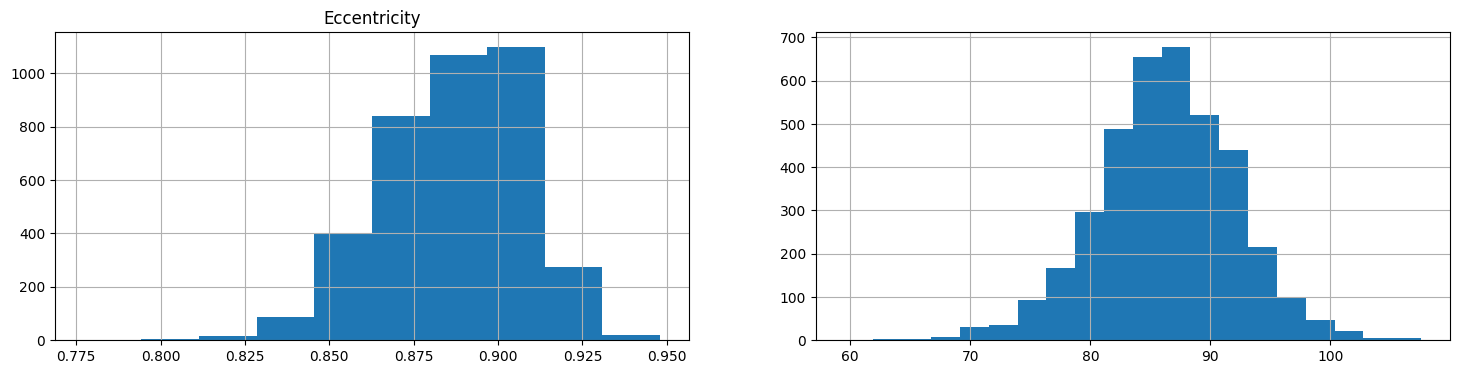

In [66]:

fig, ax = plt.subplots(1, 2, figsize=(18, 4))

rice['Eccentricity'].hist(bins=10,
                          range=(rice['Eccentricity'].min(), rice['Eccentricity'].max()),
                          ax=ax[0])
ax[0].set_title('Eccentricity')

rice['Minor_Axis_Length'].hist(bins=20,
                               range=(rice['Minor_Axis_Length'].min(), rice['Minor_Axis_Length'].max()),
                               ax=ax[1])

# non sono presenti outliers

Looking at the distribution of the variables, the outliers seem to be a result of their variability more so that mistakes, so removing them would make us lose valuable information.